**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

# **Task 3 Predictive Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our task.

In [ ]:
!pip install scikit-plot
!pip install pytorch-tabnet
!pip install wittgenstein
!pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, auc

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from scikitplot.metrics import plot_roc

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

The dataset coming from the data preparation task is saved on github.

In [ ]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


**Load the players' profile dataset**

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000


In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


## **Dataset preparation**

Load the dataset from the previous task.

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players = df_players.sample(frac=1).reset_index(drop=True)


We can discretize the categorical variables and then use them for the classification task. NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN).


In [ ]:
def discretize_data(dataset, variables):
    '''
    Function to discretize the variables
    
        input: the dataset and the list of variables' names to discretize
    '''
    for variable in variables:
        # Get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        # Generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [ ]:
def move_columns(df, cols_to_move, new_index):
    """
    This method re-arranges the columns in a dataframe to place the desired columns at the desired index.
    Usage:
        df = move_columns(df, ['Rev'], 2) 
    Input:
        df: Dataframe
        cols_to_move: The names of the columns to move. They must be a list
        new_index: The 0-based location to place the columns.
    Output:
        Dataframe with the columns re-arranged
    """
    other = [c for c in df if c not in cols_to_move]
    start = other[0:new_index]
    end = other[new_index:]
    return df[start + cols_to_move + end]

We discretize some of the categorical features.

In [ ]:
variables = ['sex', 'ioc', 'hand']
df_players = discretize_data(df_players, variables)

We assign labels to the players and check if the dataset is imbalanced: 0 to the strong players, 1 to the weak ones.

In [ ]:
df_players['label'] = np.where(df_players['rank_range'].isin(['top 10', 'top 25', 'top 50', 'top 100', 'top 250']), 1, 0)
print(df_players['label'].value_counts())

0    1010
1     590
Name: label, dtype: int64


We delete some unnecessary features and the previous discritized features. Then, we split the dataset in training set and validation set.

In [ ]:
df_players.drop(
        columns=['name', 'sex', 'ioc', 'hand', 'age_range', 'ht_range', 'rank_points', 'rank_range', 'rank',
                 'p_w_Hard', 'p_w_Clay', 'p_w_Grass', 'ioc_num', 'hand_num'],
        axis=1,
        inplace=True)
#label = df_players.pop('label')

Create two more datasets from the original one: the first one contains the male players, the other contains the female players. Afterwards we visualize how the strong players are distributed with respect to the weak ones inside the two datasets.

In [ ]:
from sklearn.model_selection import train_test_split

df_players_female = df_players[df_players['sex_num'] == 0]
print("Female distribution\n" + str(df_players_female['label'].value_counts()) + "\n")
label_f = df_players_female.pop('label')
df_players_female.pop('sex_num')
# train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_players_female, label, stratify=label, test_size=0.10)

df_players_male = df_players[df_players['sex_num'] == 1]
print("Male distribution\n" + str(df_players_male['label'].value_counts()))
label_m = df_players_male.pop('label')
df_players_male.pop('sex_num')

# train_set_m, test_set_m, train_label_m, test_label_m = train_test_split(df_players_male, label, stratify=label, test_size=0.10)
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_players['sex_num'], prefix='sex')
# Drop column B as it is now encoded
df_players.drop('sex_num', axis = 1, inplace=True)
# Join the encoded df
df_players = df_players.join(one_hot, lsuffix='sex')
label = df_players.pop('label')

Female distribution
1    304
0    194
Name: label, dtype: int64

Male distribution
0    816
1    286
Name: label, dtype: int64


The following method let's you choose the dataset on which you will do the classification task. You can use one of the two datasets based on the players's sex or one that contains both.

In [ ]:
def dataset_selector(TARGET, sampler=None, normalize = True, test_size=0.15):
  ss = StandardScaler()

  if TARGET not in ['male', 'female', 'both']:
    assert False
  elif TARGET=='male':  

    train_set, test_set, train_label, test_label = train_test_split(df_players_male, label_m, stratify=label_m, test_size=test_size)

  elif TARGET=='female':

    train_set, test_set, train_label, test_label = train_test_split(df_players_female, label_f, stratify=label_f, test_size=test_size)

  elif TARGET =='both':
    train_set, test_set, train_label, test_label = train_test_split(df_players, label, stratify=label, test_size=test_size)

  if normalize:
    columns_excl = train_set.columns.str.startswith("sex_")
    train_set_std = pd.DataFrame(ss.fit_transform(train_set.loc[:, ~columns_excl]), index=train_set.index, columns = train_set.columns[~columns_excl])
    test_set_std = pd.DataFrame(ss.fit_transform(test_set.loc[:, ~columns_excl]), index=test_set.index, columns = test_set.columns[~columns_excl])
    train_set = train_set_std.join(train_set.loc[:, columns_excl])  
    test_set = test_set_std.join(test_set.loc[:, columns_excl]) 

  if sampler is not None:
    train_set, train_label = sampler.fit_resample(train_set, train_label)
    #test_set, test_label = sampler.fit_resample(test_set, test_label)


  return train_set, test_set, train_label, test_label


Let's define the methods for analyzing the results of each classifier.

In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['weak', 'strong']))

In [ ]:
def print_scores(classifier, train_set, train_label , test_set, test_label, is_keras=False):
  train_pred = classifier.predict(train_set)
  test_pred = classifier.predict(test_set)

  if is_keras:
    train_pred = np.argmax(train_pred, 1)
    test_pred = np.argmax(test_pred, 1)

  print("Train set scores")
  report_scores(train_label, train_pred)
  print("\n______________________________________________________\n")

  print("Test set scores")
  report_scores(test_label, test_pred)

In [ ]:
def plot_feature_hist(classifier, features):
  plt.bar(features, classifier.feature_importances_)
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.show()

The dataset is imbalanced, let's solve this issue by applying oversampling on the class whose records are in minority.

In [ ]:
over_sampler = RandomOverSampler(sampling_strategy='auto')
under_sampler = RandomUnderSampler(sampling_strategy = 0.8)
smote = SMOTE(sampling_strategy= 0.8, n_jobs=-1)

train_set, test_set, train_label, test_label = dataset_selector(TARGET='male', sampler = smote, normalize = True)

train_set, train_label = under_sampler.fit_resample(train_set, train_label)
print("Distribution on train set:\n" + str(train_label.value_counts(True))+"\n")
print("Distribution on train set\n" + str(train_label.value_counts())+"\n")
print("Distribution on test set\n" + str(test_label.value_counts(True))+"\n")

Distribution on train set:
0    0.555377
1    0.444623
Name: label, dtype: float64

Distribution on train set
0    692
1    554
Name: label, dtype: int64

Distribution on test set
0    0.740964
1    0.259036
Name: label, dtype: float64



In [ ]:
#test_set = test_set.join(test_label)
#test_label = test_set[test_set['sex_0']==1].pop('label')
#test_set = test_set[test_set['sex_0']==1].drop('label', 1)

In [ ]:
test_set

,age,ht,t_won,p_wins,wins,w_Hard,w_Clay,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced
235,0.532737,0.376665,-0.492433,0.618479,-0.507801,-0.664843,-0.083664,-0.411917,-1.098942,-1.291622,0.674955,0.284842,-0.776508,-0.255838,0.082844,-0.474614,-0.242033,0.211151,0.810333,0.631420
1084,-0.130521,-0.767982,-0.492433,-1.587286,-0.800731,-0.745127,-0.561389,-0.411917,-0.875345,0.293957,-0.628202,-0.165479,-0.684028,-0.524629,-1.621908,0.024031,0.293667,-0.397550,0.810333,1.629664
704,-0.351606,0.233584,-0.492433,0.049380,-0.680113,-0.450752,-0.697882,-0.411917,-1.002564,-0.545862,-0.502480,0.059681,-0.959096,-0.524629,0.495609,1.021320,0.293667,-1.050360,0.810333,0.631420
497,-0.793778,-0.338740,0.063648,1.009785,0.905156,-0.129615,1.929608,0.157901,-0.805953,-0.680233,-0.021352,0.059681,0.048697,0.012954,0.425137,0.024031,0.115100,0.409640,0.810333,-0.366825
1081,1.195995,1.521311,0.063648,-0.026121,0.267602,0.432374,0.052829,-0.411917,2.817861,0.831441,-0.415442,-0.390640,1.884066,0.550537,0.022439,0.522676,-0.063467,0.464776,-0.576423,-1.365069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,-0.351606,0.519746,-0.492433,-0.853384,-0.645650,-0.504275,-0.561389,-0.411917,-0.324062,1.214399,-0.011681,-0.840961,-0.446900,-0.793421,-0.809801,-0.973258,-1.134867,-0.871719,-0.576423,-0.366825
1014,-0.793778,-0.624901,-0.492433,1.073920,-0.473338,-0.504275,-0.220157,-0.411917,-0.937027,-0.666796,-0.282467,0.059681,-0.665058,-0.255838,0.401646,0.522676,0.472234,0.087646,0.810333,0.631420
198,0.090565,-0.052578,0.063648,0.036391,0.009135,0.459135,-0.493143,-0.411917,-0.462847,-0.680233,-0.023770,-0.390640,0.041583,-0.255838,0.814411,0.024031,-0.420600,-0.082172,-0.576423,-0.366825
1559,-0.130521,-1.483386,-0.492433,0.680991,-0.766268,-0.611320,-0.732005,-0.032038,-1.125928,0.764256,-1.368028,-1.966764,-0.091208,-1.599795,-0.175553,0.024031,-1.492001,-1.694347,-1.963179,-1.365069


## **Classification**
Let's see how each classifier performs on the labelled dataset.

In this section we will compare different classifiers: Decision tree, Naive Bayes, Random forest, Adaboost, Rule based, KNN, SVM, Neural Network and TabNet.

The approach used for each algorithm is the following:

1. perform K-Fold Cross-validation to look for the best hyperparameters for each model.

2. evaluate the trained model by using the best hyperparameters found at the previous step based on the following metrics: precisione, recall and F1 (anche accuracy).

3. plot the confusion matrix and the ROC curve.

4. (only for the explainable models) show how each feature affects the model output and/or the classifications rules produced by it.

### **Decision tree**

In [ ]:
dt = tree.DecisionTreeClassifier(splitter='best', max_depth = 4, criterion = 'gini')
dt.fit(train_set, train_label)
print_scores(dt, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.99      0.90      0.94       692
      strong       0.89      0.98      0.93       554

    accuracy                           0.94      1246
   macro avg       0.94      0.94      0.94      1246
weighted avg       0.94      0.94      0.94      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.87      0.93       123
      strong       0.72      0.98      0.83        43

    accuracy                           0.90       166
   macro avg       0.86      0.92      0.88       166
weighted avg       0.92      0.90      0.90       166



#### **Grid search for best hyperparameters**

In [ ]:
#define the parameters' values you want to try
param_dist = {"max_depth": [3,4,5,6,7],
              "min_samples_split": list(np.arange(2, 21, 3)),
              "min_samples_leaf": list(np.arange(2, 21, 3)),
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 1500
#define the model
dt = tree.DecisionTreeClassifier(splitter='best')
#define the grid search
grid_search = GridSearchCV(dt, param_dist, 
                            #n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=10, 
                            scoring=make_scorer(accuracy_score),
                            cv = 5)

#GridSearchCV()
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 5 folds for each of 980 candidates, totalling 4900 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [2, 5, 8, 11, 14, 17, 20],
                         'min_samples_split': [2, 5, 8, 11, 14, 17, 20]},
             scoring=make_scorer(accuracy_score), verbose=10)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 17}
Mean and std of this setting  0.9205236947791164 0.02433014878832963


In [ ]:
best_param = grid_search.best_params_
dt = tree.DecisionTreeClassifier( criterion=best_param['criterion'],
                             max_depth=best_param['max_depth'], 
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             class_weight = best_param['class_weight']) 
dt = dt.fit(train_set, train_label)
print_scores(dt, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.97      0.96      0.96       692
      strong       0.95      0.96      0.96       554

    accuracy                           0.96      1246
   macro avg       0.96      0.96      0.96      1246
weighted avg       0.96      0.96      0.96      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.92      0.95       123
      strong       0.81      0.98      0.88        43

    accuracy                           0.93       166
   macro avg       0.90      0.95      0.92       166
weighted avg       0.94      0.93      0.94       166



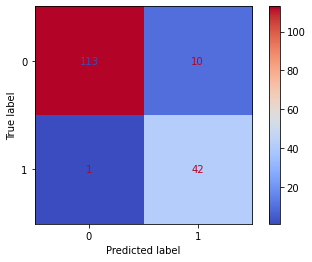

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(dt, test_set, test_label, cmap='coolwarm')
plt.show() 

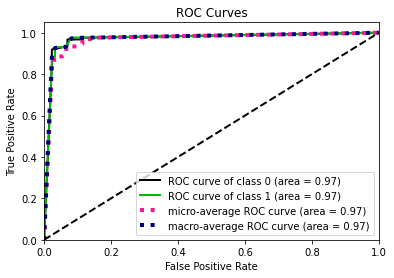

In [ ]:
plot_roc(test_label, dt.predict_proba(test_set))
plt.show()

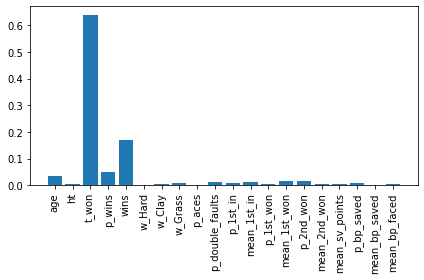

In [ ]:
plot_feature_hist(dt, train_set.columns.values)

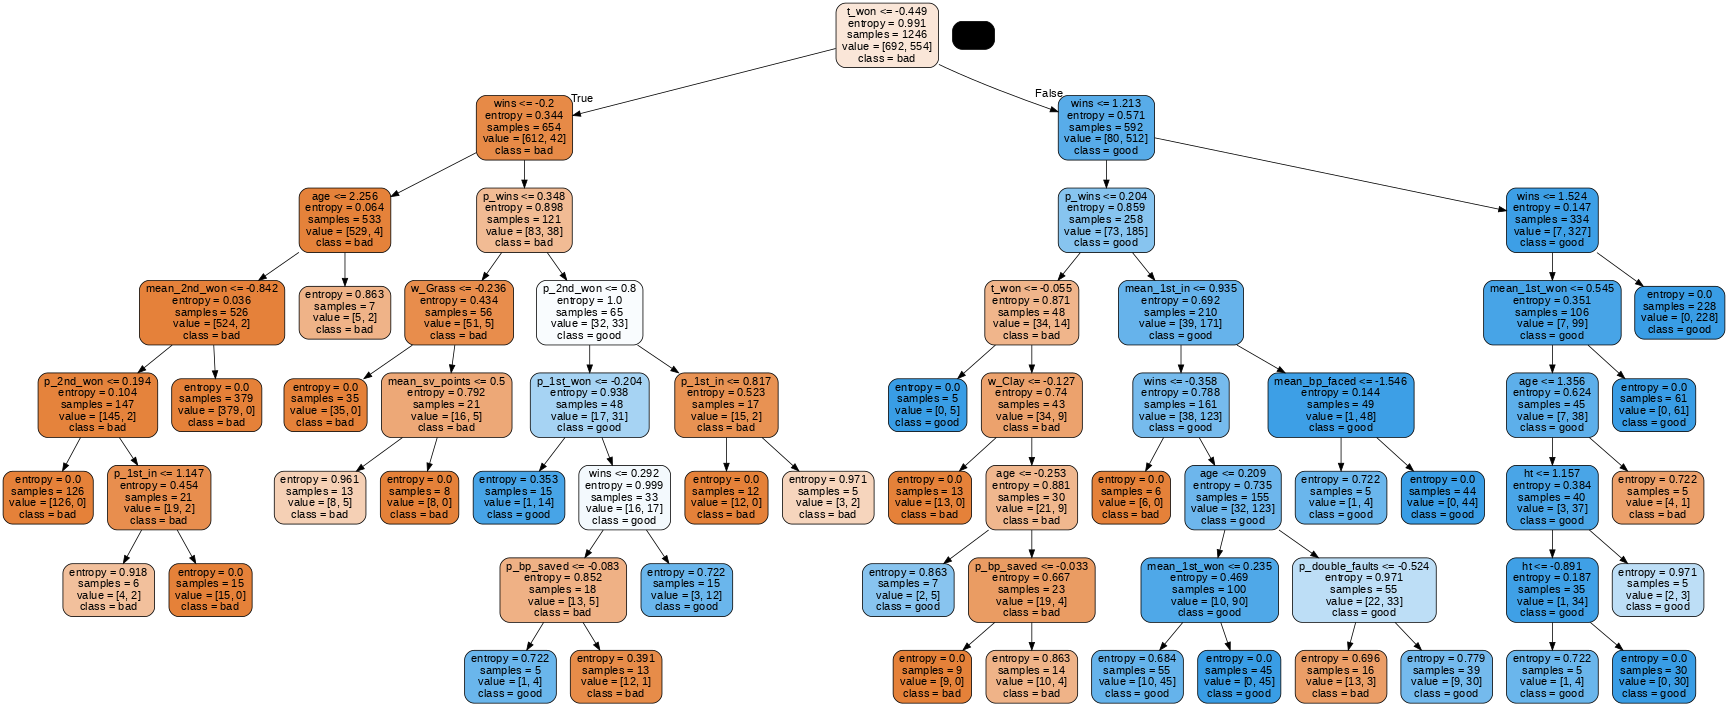

In [ ]:
import graphviz, pydotplus
from IPython.display import Image  
# DOT data
dot_data = tree.export_graphviz(dt, out_file = None, 
                                feature_names= list(train_set.columns.values),
                                class_names=['bad', 'good'],
                                filled=True,
                                rounded = True)
# Draw graph

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"18, 18!"')
Image(pydot_graph.create_png())

### **Naive Bayes**

In [ ]:
#define and fit the model
gnb = GaussianNB()
gnb.fit(train_set, train_label)

#compute the performance of the model
print_scores(gnb, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.94      0.89      0.92       692
      strong       0.88      0.92      0.90       554

    accuracy                           0.91      1246
   macro avg       0.91      0.91      0.91      1246
weighted avg       0.91      0.91      0.91      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.97      0.90      0.93       123
      strong       0.76      0.91      0.83        43

    accuracy                           0.90       166
   macro avg       0.86      0.90      0.88       166
weighted avg       0.91      0.90      0.91       166



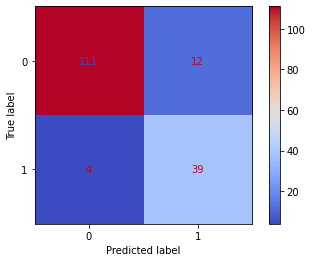

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(gnb, test_set, test_label, cmap = 'coolwarm')
plt.show() 

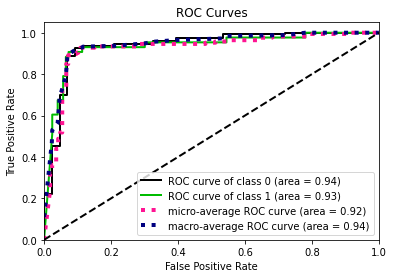

In [ ]:
plot_roc(test_label, gnb.predict_proba(test_set))
plt.show()

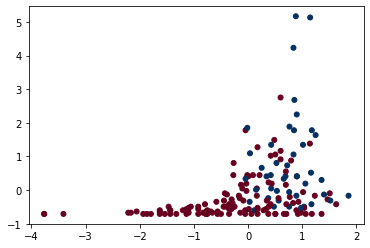

In [ ]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_label.values, s=25, cmap='RdBu');

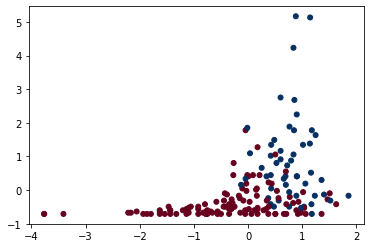

In [ ]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=gnb.predict(test_set), s=25, cmap='RdBu');

### **Random forest**

In [ ]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini',
                             max_features=5,
                             max_depth=4,
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

#compute the performance of the model
print_scores(rf, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.97      0.92      0.95       692
      strong       0.91      0.96      0.94       554

    accuracy                           0.94      1246
   macro avg       0.94      0.94      0.94      1246
weighted avg       0.94      0.94      0.94      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.94      0.97       123
      strong       0.86      0.98      0.91        43

    accuracy                           0.95       166
   macro avg       0.92      0.96      0.94       166
weighted avg       0.96      0.95      0.95       166



#### **Grid search for best hyperparameters**

In [ ]:
#define the parameters' values you want to try
param_dist = {"n_estimators": list(np.arange(100, 350, 50)),
              "max_depth": [4,5,6,7],
              "max_features": list(np.arange(3, len(train_set.iloc[0])//2 + 1, 1)),
              "min_samples_split": list(np.arange(2, 11, 2)),
              "min_samples_leaf": list(np.arange(2, 11, 2)),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 300
#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=5, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [4, 5, 6, 7],
                                        'max_features': [3, 4, 5, 6, 7, 8, 9,
                                                         10],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   scoring=make_scorer(accuracy_score), verbose=5)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 9, 'max_depth': 7, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}
Mean and std of this setting  0.938195646796933 0.008352486934223568


In [ ]:
best_param = grid_search.best_params_
rf = RandomForestClassifier(n_estimators=best_param['n_estimators'], 
                             criterion=best_param['criterion'],
                             max_features=best_param['max_features'],
                             max_depth=best_param['max_depth'], 
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             bootstrap=best_param['bootstrap'],
                             class_weight = best_param['class_weight']) 
rf = rf.fit(train_set, train_label)
#compute the performance of the model
print_scores(rf, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       1.00      0.98      0.99       692
      strong       0.97      1.00      0.99       554

    accuracy                           0.99      1246
   macro avg       0.99      0.99      0.99      1246
weighted avg       0.99      0.99      0.99      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.93      0.96       123
      strong       0.84      0.98      0.90        43

    accuracy                           0.95       166
   macro avg       0.92      0.96      0.93       166
weighted avg       0.95      0.95      0.95       166



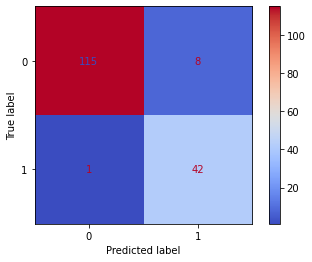

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(rf, test_set, test_label, cmap='coolwarm')
plt.show() 

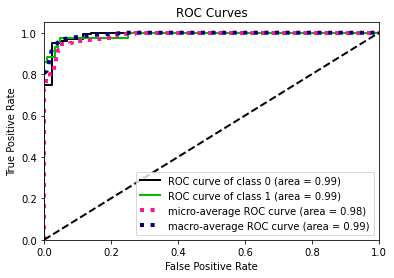

In [ ]:
plot_roc(test_label, rf.predict_proba(test_set))
plt.show()

In [ ]:
rf.predict(test_set).shape

(166,)

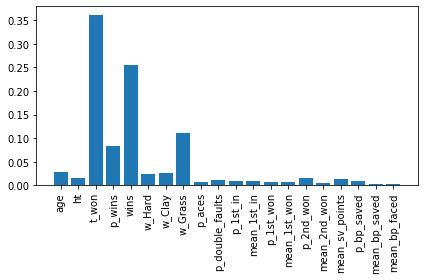

In [ ]:
plot_feature_hist(rf, train_set.columns.values)

### **AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(train_set, train_label)

print_scores(ada, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.96      0.96      0.96       692
      strong       0.94      0.96      0.95       554

    accuracy                           0.96      1246
   macro avg       0.95      0.96      0.96      1246
weighted avg       0.96      0.96      0.96      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.70      0.82       123
      strong       0.53      0.98      0.69        43

    accuracy                           0.77       166
   macro avg       0.76      0.84      0.75       166
weighted avg       0.87      0.77      0.79       166



In [ ]:
base = tree.DecisionTreeClassifier(max_depth = 6)
ada_tree = AdaBoostClassifier(base_estimator = base, n_estimators=200, learning_rate=0.1)
ada_tree.fit(train_set, train_label)

print_scores(ada_tree, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       1.00      1.00      1.00       692
      strong       1.00      1.00      1.00       554

    accuracy                           1.00      1246
   macro avg       1.00      1.00      1.00      1246
weighted avg       1.00      1.00      1.00      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.98      0.89      0.94       123
      strong       0.76      0.95      0.85        43

    accuracy                           0.91       166
   macro avg       0.87      0.92      0.89       166
weighted avg       0.92      0.91      0.91       166



#### **Grid search for best hyperparameters**

In [ ]:
#define the parameters' values you want to try
trees_params = [tree.DecisionTreeClassifier(max_depth = 6), tree.DecisionTreeClassifier(max_depth = 7)]
param_dist = {"base_estimator" : trees_params,
              "n_estimators": list(np.arange(150, 350, 50)),
              "learning_rate": np.arange(0.04, 0.12, 0.02)}
#define the number of iters
n_iter_search = 40
#define the model
ada_tree = AdaBoostClassifier()
#define the grid search
grid_search = GridSearchCV(ada_tree, param_dist, 
                            #n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=10, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=6),
                                            DecisionTreeClassifier(max_depth=7)],
                         'learning_rate': array([0.04, 0.06, 0.08, 0.1 ]),
                         'n_estimators': [150, 200, 250, 300]},
             scoring=make_scorer(accuracy_score), verbose=10)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'base_estimator': DecisionTreeClassifier(max_depth=7), 'learning_rate': 0.09999999999999999, 'n_estimators': 300}
Mean and std of this setting  0.937433011789925 0.021378857450198296


In [ ]:
best_param = grid_search.best_params_
ada_tree = AdaBoostClassifier(n_estimators=best_param['n_estimators'], 
                        learning_rate=best_param['learning_rate']) 
ada_tree = ada_tree.fit(train_set, train_label)
#compute the performance of the model
print_scores(ada_tree, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.96      0.95      0.96       692
      strong       0.94      0.95      0.94       554

    accuracy                           0.95      1246
   macro avg       0.95      0.95      0.95      1246
weighted avg       0.95      0.95      0.95      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.99      0.85      0.92       123
      strong       0.70      0.98      0.82        43

    accuracy                           0.89       166
   macro avg       0.85      0.92      0.87       166
weighted avg       0.92      0.89      0.89       166



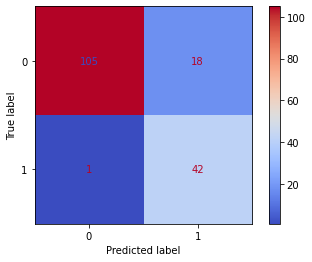

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(ada_tree, test_set, test_label, cmap='coolwarm')
plt.show() 

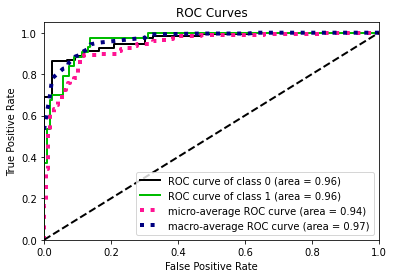

In [ ]:
plot_roc(test_label, ada_tree.predict_proba(test_set))
plt.show()

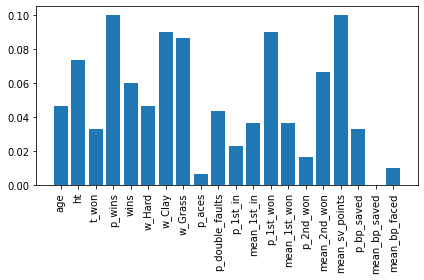

In [ ]:
plot_feature_hist(ada_tree, train_set.columns.values)

### **Rule based**

In [ ]:
#we run a grid search to find the best configuration of parameters' values
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.4, 0.5, 0.6, 0.7], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(k=2, max_total_conds=None, max_rule_conds=None, prune_size=0.33, n_discretize_bins=10, dl_allowance=64, random_state=None, verbosity=0, max_rules=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.4, 0.5, 0.6, 0.7]})

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'k': 5, 'prune_size': 0.7}
Mean and std of this setting  0.8551724137931034 0.02693189543416088


In [ ]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
best_param = grid_search.best_params_
ripper = lw.RIPPER(k=best_param['k'], prune_size=best_param['prune_size'])
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='label', pos_class=1)

In [ ]:
#in this case the model is a set of rules
ripper.out_model()

[[mean_bp_faced=<-1.08 ^ p_wins=>1.3] V
[p_wins=0.98-1.3 ^ wins=0.53-0.89] V
[wins=1.45-1.93] V
[t_won=0.63-1.35] V
[wins=0.029-0.53 ^ p_double_faults=0.028-0.35] V
[p_wins=0.72-0.98] V
[mean_1st_in=0.48-0.68 ^ wins=0.029-0.53] V
[wins=0.89-1.45] V
[p_2nd_won=>1.27 ^ mean_bp_faced=<-1.08] V
[w_Grass=-0.19-0.13 ^ ht=0.23-0.55] V
[wins=0.53-0.89] V
[t_won=>1.35]]


In [ ]:
print_scores(ripper, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.91      0.85      0.88       322
      strong       0.83      0.90      0.86       258

    accuracy                           0.87       580
   macro avg       0.87      0.87      0.87       580
weighted avg       0.87      0.87      0.87       580


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.92      0.79      0.85        57
      strong       0.54      0.78      0.64        18

    accuracy                           0.79        75
   macro avg       0.73      0.78      0.74        75
weighted avg       0.83      0.79      0.80        75



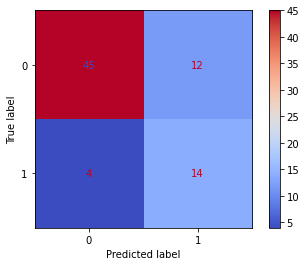

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(ripper, test_set, test_label, cmap= 'coolwarm')
plt.show() 

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [23, 42]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



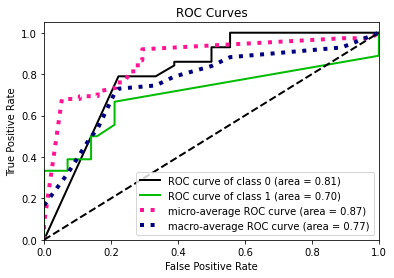

In [ ]:
plot_roc(test_label, ripper.predict_proba(test_set))
plt.show()

### **KNN**

In [ ]:
#drop the categorical features
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#['auto', 'ball_tree', 'kd_tree', 'brute']
knn = KNeighborsClassifier(n_neighbors=60, algorithm='auto', metric='minkowski').fit(train_set_no_cat, train_label)

#compute the performance of the model
print_scores(knn, train_set_no_cat, train_label, test_set_no_cat, test_label)

#### **Grid search for best hyperparameters**

In [ ]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#define the parameters' values you want to try
param_dist = {"n_neighbors": list(np.arange(5, 30, 3)),
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "p": [1, 2],
              "metric": ['minkowski']}
#define the number of iters
n_iter_search = 100
#define the model
knn = KNeighborsClassifier()
#define the grid search
grid_search = GridSearchCV(knn, param_dist, 
                            #n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=5, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set_no_cat, train_label)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

In [ ]:
best_param = grid_search.best_params_
knn = KNeighborsClassifier(n_neighbors=best_param['n_neighbors'],
                          algorithm=best_param['algorithm'],
                          metric=best_param['metric'],
                          p = best_param['p'])
knn = knn.fit(train_set_no_cat, train_label)

#compute the performance of the model
print_scores(knn, train_set_no_cat, train_label, test_set_no_cat, test_label)

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(knn, test_set_no_cat, test_label, cmap='coolwarm')
plt.show()

In [ ]:
plot_roc(test_label, knn.predict_proba(test_set))
plt.show()

### **SVM**

In [ ]:
#linear,poly,rbf,sigmoid,precomputed
svm = SVC(kernel='sigmoid', C = 2, gamma='scale', probability=True)
svm.fit(train_set, train_label)

#compute the performance of the model
print_scores(svm, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.87      0.86      0.86       692
      strong       0.83      0.83      0.83       554

    accuracy                           0.85      1246
   macro avg       0.85      0.85      0.85      1246
weighted avg       0.85      0.85      0.85      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.95      0.88      0.91       123
      strong       0.71      0.86      0.78        43

    accuracy                           0.87       166
   macro avg       0.83      0.87      0.85       166
weighted avg       0.89      0.87      0.88       166



#### **Grid search for best hyperparameters**

In [ ]:
#to find the best set of parameter setting, we can run a grid search
#define the parameters' values you want to try
param_dist = {"C": list(np.arange(1, 20, 2)),
              "kernel": ['poly', 'rbf', 'sigmoid'],
              "degree": list(np.arange(2, 10, 1)),
              "class_weight":['balanced']}
#define the number of iters
n_iter_search = 150
#define the model
svm = SVC()
#define the grid search
grid_search = GridSearchCV(svm, param_dist, 
                            #n_iter=n_iter_search, 
                            n_jobs= -1,
                            verbose = 3, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 240 candidates, totalling 960 fits


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'class_weight': ['balanced'],
                         'degree': [2, 3, 4, 5, 6, 7, 8, 9],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(accuracy_score), verbose=3)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'C': 19, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}
Mean and std of this setting  0.9366059650424603 0.009121917457021789


In [ ]:
best_param = grid_search.best_params_
svm = SVC(C=best_param['C'],
          kernel=best_param['kernel'],
          degree=best_param['degree'],
          class_weight = best_param['class_weight'],
          probability=True)
svm = svm.fit(train_set, train_label)

#compute the performance of the model
print_scores(svm, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       1.00      0.98      0.99       692
      strong       0.97      0.99      0.98       554

    accuracy                           0.98      1246
   macro avg       0.98      0.99      0.98      1246
weighted avg       0.98      0.98      0.98      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.95      0.96      0.96       123
      strong       0.88      0.86      0.87        43

    accuracy                           0.93       166
   macro avg       0.92      0.91      0.91       166
weighted avg       0.93      0.93      0.93       166



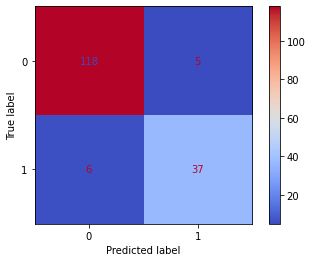

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(svm, test_set, test_label, cmap='coolwarm')
plt.show()

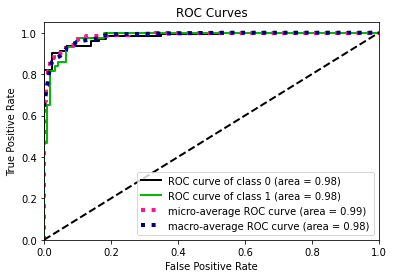

In [ ]:
test_pred_proba = svm.predict_proba(test_set)
plot_roc(test_label.values, test_pred_proba)
plt.show()

### **Neural network**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


In [ ]:
columns_to_one_hot = list(train_set.columns[train_set.columns.str.contains('_num', case=False)])
train_set_nn = pd.get_dummies(train_set, columns= columns_to_one_hot)
test_set_nn = pd.get_dummies(test_set, columns= columns_to_one_hot)
train_set_nn
#test_set_nn = (tf.constant(test_set_nn, dtype=tf.float32), tf.constant(test_label, dtype=tf.int32))

,age,ht,t_won,p_wins,wins,w_Hard,w_Clay,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced
0,-1.470995,0.057637,-0.392403,-1.658033,-0.863180,-0.808155,-0.804938,-0.680534,1.044064,1.364335,-0.355472,-0.292194,0.074834,-0.128149,-1.251358,-0.126154,0.038028,0.056302,-0.127343,0.725394
1,0.760823,0.859631,-0.392403,-1.828465,-0.863180,-0.839662,-0.732816,-0.680534,-0.783057,0.321915,-0.023697,-0.770331,-0.880903,-1.281487,-0.466514,-0.644241,-1.340749,-2.149384,-1.623622,-0.171804
2,0.760823,0.218036,-0.392403,-0.005144,-0.214979,-0.146511,-0.444327,0.080613,1.054243,-0.564679,-0.484035,-0.292194,0.797053,0.256297,0.779626,0.910021,0.038028,1.159145,-0.127343,-0.171804
3,0.537641,-2.187945,-0.392403,-0.293036,-0.863180,-0.808155,-0.804938,-0.680534,-0.034904,0.719539,-0.401091,-0.770331,0.041131,-0.512595,0.846898,0.391934,-0.651361,1.310515,-0.127343,-1.069002
4,-0.355086,-1.867148,-0.392403,-0.139494,-0.507715,-0.335552,-0.660693,-0.680534,-0.503136,0.090863,-0.282896,-0.292194,-0.291090,-0.512595,-1.456378,-0.644241,0.038028,-0.820687,-0.127343,0.725394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,-0.427357,0.283708,1.123669,1.119272,0.894428,0.670870,1.702157,-0.322436,0.401477,-0.188608,-0.138375,-0.369610,0.863421,0.391760,0.850535,0.391934,-0.415007,1.107239,-0.127343,-1.069002
576,-0.006865,0.433032,2.508399,1.114303,2.825815,2.439051,3.010370,2.434216,1.116781,-0.775864,0.264862,0.372446,0.789313,0.856132,1.656369,0.391934,0.318350,0.977683,-0.127343,-0.871733
577,-0.413292,0.610307,-0.392403,1.351713,0.559366,0.680885,0.089550,0.593565,1.168532,-1.342806,0.398196,0.380830,1.139183,1.267544,1.992685,0.583419,0.165427,1.534242,-0.127343,-1.800397
578,0.537641,0.345796,5.208198,1.910735,3.383366,2.404786,5.173862,2.092406,0.989741,-0.275896,0.010945,-0.585668,1.353893,0.256297,0.881575,-0.067202,-0.855009,0.835557,-1.623622,-1.966200


In [ ]:
# = np.asarray(train_label, dtype=np.float32).reshape((train_label.shape[0], 1))
train_set_nn, val_set_nn, train_label_nn, val_label_nn = train_test_split(train_set, train_label, test_size=0.2)

patterns = tf.convert_to_tensor(train_set_nn, dtype=tf.float32)
targets =  tf.convert_to_tensor(train_label_nn.T, dtype=tf.int32)
train_set_nn = tf.data.Dataset.from_tensor_slices((patterns,targets))

patterns = tf.convert_to_tensor(val_set_nn, dtype=tf.float32)
targets =  tf.convert_to_tensor(val_label_nn.T, dtype=tf.int32)
val_set_nn = tf.data.Dataset.from_tensor_slices((patterns,targets))

patterns = tf.convert_to_tensor(test_set, dtype=tf.float32)
targets =  tf.convert_to_tensor(test_label.T, dtype=tf.int32)
test_set_nn = tf.data.Dataset.from_tensor_slices((patterns,targets))

In [ ]:
for p,l in test_set_nn:

  print([p,l])
  break;

[<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.10374758,  0.09334009, -0.4557327 , -1.1040668 , -0.7655579 ,
       -0.74393374, -0.58974963, -0.70419526, -0.48928854,  1.6002039 ,
       -0.33221447, -0.67299753, -1.0164639 , -1.2306294 , -0.39136612,
       -0.08980265, -0.7639933 , -1.200625  , -0.2746569 , -0.21703304],
      dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>]


In [ ]:
BUFFER_SIZE = 20000
DS_SIZE= 2**15

def make_dataset(dataset, batch_size):
    dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE).cache()

batch_size =  16 * strategy.num_replicas_in_sync
with strategy.scope():
  train_set_nn = make_dataset(train_set_nn, batch_size)
  test_set_nn = make_dataset(test_set_nn, batch_size)
  val_set_nn = make_dataset(val_set_nn, batch_size)

In [ ]:
monitor = "val_Accuracy"
with strategy.scope():
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor=monitor,
      patience=30,
      verbose=1,
      mode="max",
      baseline=None,
      restore_best_weights=True,
  )

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/model_weights.h5',
    monitor=monitor,
    verbose=0,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    overwrite=True)

In [ ]:
#from tf.keras.regularizers import l2

shape= train_set.shape
dropout = 0.1
def create_model():
  input = tf.keras.Input(shape=(shape[1]), dtype="float32", name='input')
  x = tf.keras.layers.Dense(64, activation='elu', name='dense1')(input)
  x = tf.keras.layers.LayerNormalization()(x)
  l1 = tf.keras.layers.Dropout(dropout)(x)

  #x = tf.keras.layers.Dense(32, activation='elu', name='dense2')(l1)
  #x = tf.keras.layers.LayerNormalization()(x)
  #x = tf.keras.layers.Dropout(dropout)(x)

  '''x = tf.keras.layers.Dense(96, activation='elu', name='dense3')(l1)
  x = tf.keras.layers.LayerNormalization()(x)
  x3 = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Add()([x2, x3])
  x = tf.keras.layers.Dropout(dropout)(x)'''
  x = tf.keras.layers.Dense(32, activation='elu', name='dense4')(x)
  #x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.LayerNormalization()(x)
  
  out = tf.keras.layers.Dense(2, activation='softmax', name='out')(x)

  return tf.keras.Model(input, out)

with strategy.scope():
  
  model = create_model()
  model.compile(optimizer=tf.keras.optimizers.Adam(0.1e-3),
                loss= tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['Accuracy'])
#tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
history = model.fit(train_set_nn,
                    epochs=100,
                    validation_data = val_set_nn,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
29/29 [==============================] - 2s 16ms/step - loss: 0.8771 - Accuracy: 0.3685 - val_loss: 0.6680 - val_Accuracy: 0.6034
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 0.6037 - Accuracy: 0.6616 - val_loss: 0.5159 - val_Accuracy: 0.7672
Epoch 3/100
29/29 [==============================] - 0s 7ms/step - loss: 0.4848 - Accuracy: 0.7759 - val_loss: 0.4421 - val_Accuracy: 0.8017
Epoch 4/100
29/29 [==============================] - 0s 7ms/step - loss: 0.4245 - Accuracy: 0.7974 - val_loss: 0.3968 - val_Accuracy: 0.8448
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.3871 - Accuracy: 0.8276 - val_loss: 0.3654 - val_Accuracy: 0.8448
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.3617 - Accuracy: 0.8319 - val_loss: 0.3424 - val_Accuracy: 0.8707
Epoch 7/100
29/29 [==============================] - 0s 7ms/step - loss: 0.3436 - Accuracy: 0.8427 - val_loss: 0.3250 - val_Accuracy: 0.8879
Epoch 8/100


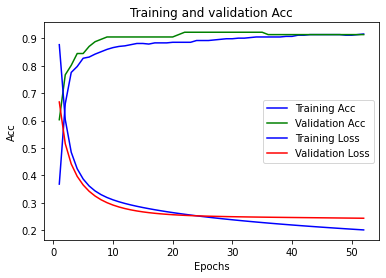

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
#compute the performance of the model
test_nn = test_set.to_numpy()
train_nn = train_set.to_numpy()

print_scores(model, train_nn, train_label, test_nn, test_label, True)

Train set scores
              precision    recall  f1-score   support

        weak       0.92      0.89      0.91       322
      strong       0.87      0.91      0.89       258

    accuracy                           0.90       580
   macro avg       0.89      0.90      0.90       580
weighted avg       0.90      0.90      0.90       580


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.98      0.88      0.93        57
      strong       0.71      0.94      0.81        18

    accuracy                           0.89        75
   macro avg       0.84      0.91      0.87        75
weighted avg       0.92      0.89      0.90        75



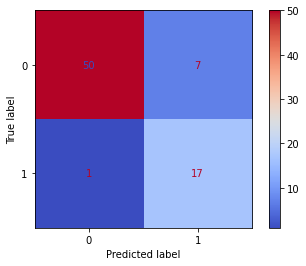

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_predictions(test_label, np.argmax(model.predict(test_nn), 1), cmap='coolwarm')

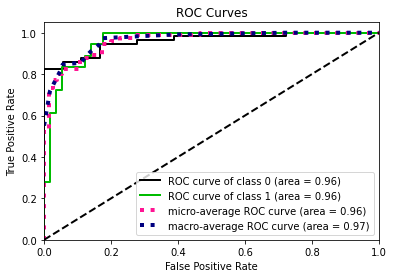

In [ ]:
plot_roc(test_label, model.predict(test_nn))
plt.show()

### **Tab Net**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Accuracy, AUC
import torch
from sklearn.preprocessing import StandardScaler

train_set_tab, val_set_tab, train_label_tab, val_label_tab = train_test_split(train_set, train_label, test_size=0.2)

train_set_tab = train_set.to_numpy()
test_set_tab = test_set.to_numpy()

In [ ]:
tab_clf = TabNetClassifier(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=7e-2))  #4e-2 for female, 6e-2 for male/both

tab_clf.fit(
  train_set_tab, train_label.to_numpy(),
  eval_set=[(val_set_tab.to_numpy(), val_label_tab.to_numpy())],
  eval_metric=[AUC, Accuracy]
)

Device used : cpu
epoch 0  | loss: 0.69224 | val_0_auc: 0.72247 | val_0_accuracy: 0.6     |  0:00:00s
epoch 1  | loss: 0.58111 | val_0_auc: 0.88633 | val_0_accuracy: 0.716   |  0:00:00s
epoch 2  | loss: 0.46493 | val_0_auc: 0.90454 | val_0_accuracy: 0.752   |  0:00:00s
epoch 3  | loss: 0.3411  | val_0_auc: 0.92607 | val_0_accuracy: 0.78    |  0:00:00s
epoch 4  | loss: 0.26812 | val_0_auc: 0.93757 | val_0_accuracy: 0.84    |  0:00:00s
epoch 5  | loss: 0.27498 | val_0_auc: 0.95716 | val_0_accuracy: 0.896   |  0:00:00s
epoch 6  | loss: 0.26736 | val_0_auc: 0.96575 | val_0_accuracy: 0.904   |  0:00:00s
epoch 7  | loss: 0.22028 | val_0_auc: 0.97092 | val_0_accuracy: 0.916   |  0:00:00s
epoch 8  | loss: 0.22373 | val_0_auc: 0.97132 | val_0_accuracy: 0.904   |  0:00:00s
epoch 9  | loss: 0.22154 | val_0_auc: 0.96582 | val_0_accuracy: 0.9     |  0:00:00s
epoch 10 | loss: 0.23704 | val_0_auc: 0.96042 | val_0_accuracy: 0.896   |  0:00:00s
epoch 11 | loss: 0.21614 | val_0_auc: 0.96141 | val_0_accu

In [ ]:
#compute the performance of the model
print_scores(tab_clf, train_set_tab, train_label, test_set_tab, test_label)

Train set scores
              precision    recall  f1-score   support

        weak       0.95      0.89      0.92       692
      strong       0.87      0.94      0.90       554

    accuracy                           0.91      1246
   macro avg       0.91      0.91      0.91      1246
weighted avg       0.91      0.91      0.91      1246


______________________________________________________

Test set scores
              precision    recall  f1-score   support

        weak       0.95      0.89      0.92       123
      strong       0.74      0.86      0.80        43

    accuracy                           0.89       166
   macro avg       0.84      0.88      0.86       166
weighted avg       0.89      0.89      0.89       166



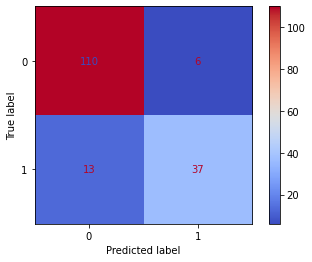

In [ ]:
y_pred = tab_clf.predict_proba(test_set_tab)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_pred, 1), test_label, cmap='coolwarm')

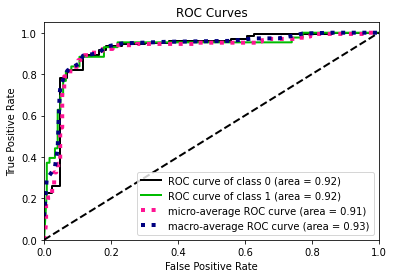

In [ ]:
plot_roc(test_label, y_pred)
plt.show()

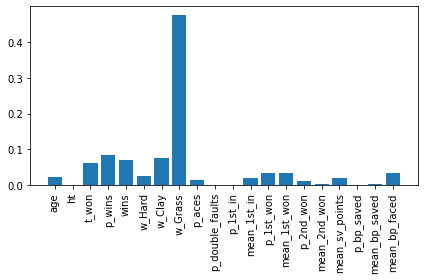

In [ ]:
plot_feature_hist(tab_clf, train_set.columns.values)

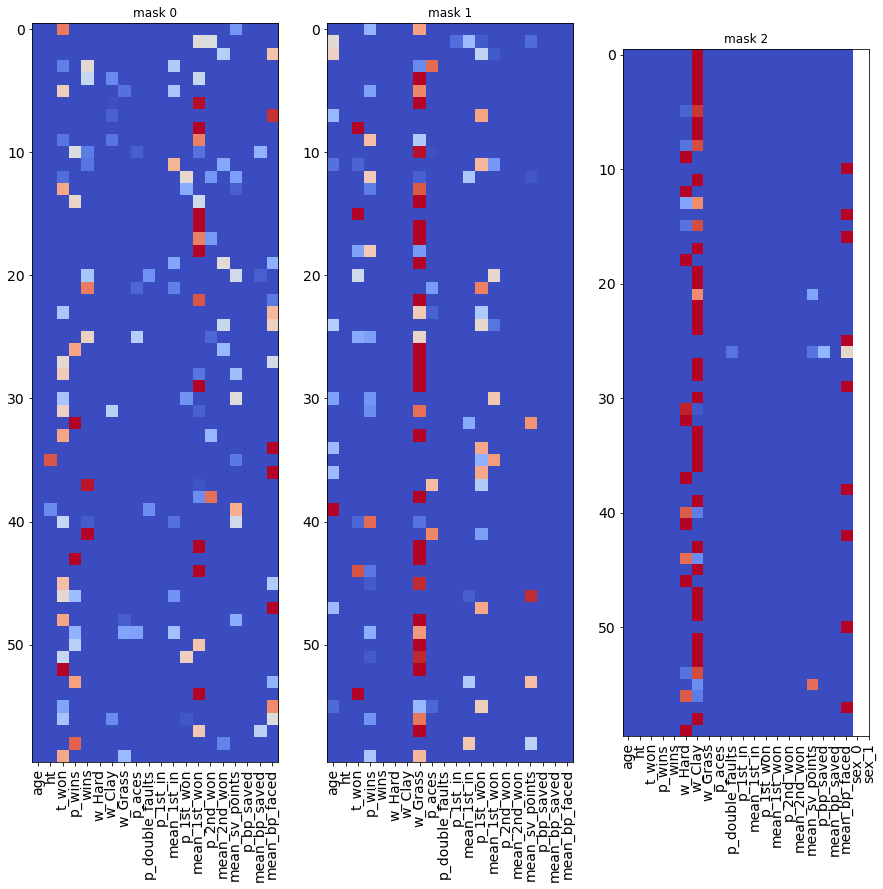

In [ ]:
from matplotlib.pyplot import Axes
explain_matrix, masks = tab_clf.explain(test_set_tab)
fig, axs = plt.subplots(1, len(masks), figsize=(15, 15), sharex=True)
for i in range(len(masks)):
    axs[i].imshow(masks[i][:60], cmap='coolwarm')
    axs[i].set_xticks(list(np.arange(0, len(df_players.columns.values), 1)))
    axs[i].set_xticklabels(df_players.columns.values, rotation=90)
    # We change the fontsize of minor ticks label 
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_title(f"mask {i}")

## **Result comparison**

NameError: ignored

<Figure size 432x288 with 0 Axes>

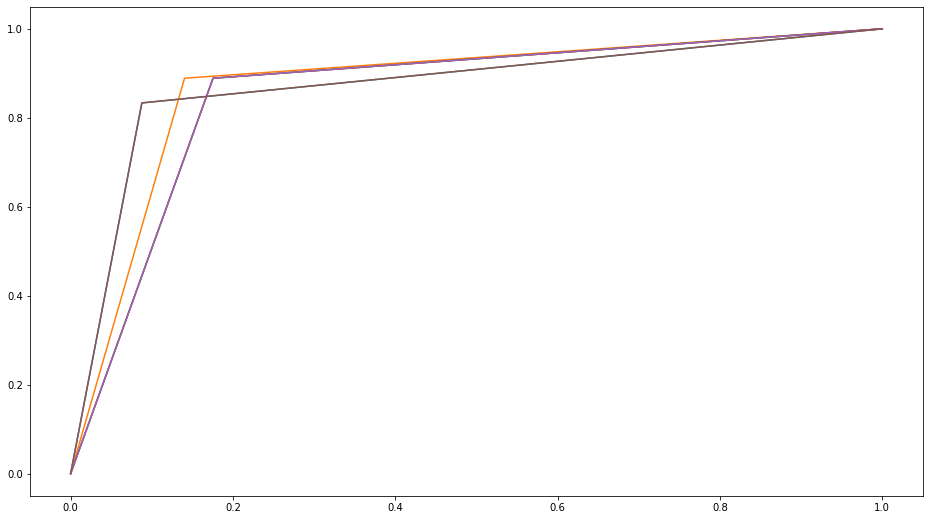

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(16,9))
def auc_plot(classifier, test_set, test_label, name, is_keras=False, proba=False):
  #if proba:
   # test_pred = classifier.predict_proba(test_set)
  #else:  
  test_pred = classifier.predict(test_set)
  if is_keras: 
    test_pred = np.argmax(test_pred, 1)

  fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred)
  auc = metrics.roc_auc_score(test_label, test_pred)
  plt.plot(fpr,tpr,label= name + ", auc=" + str(auc))

auc_plot(ada, test_set, test_label, "AdaBoost")
auc_plot(rf, test_set, test_label, "RandomForest")
auc_plot(dt, test_set, test_label, "DecisionTree")
auc_plot(gnb, test_set, test_label, "NaiveBayes")
auc_plot(dt, test_set, test_label, "DecisionTree")
auc_plot(svm, test_set, test_label, "SVM")
auc_plot(ripper, test_set, test_label, "RuleBased")
auc_plot(model, test_nn, test_label, "NN", True)
auc_plot(tab_clf, test_set_tab, test_label, "TabNet")

plt.legend(loc=0)